

| Task | Sub Task |
|-----------------|-----------------|
| Data Preprocessing    | Scaling and Resizing<br> Image Augmentation<br> Train and test data handled correctly<br> Gaussian Blur, Histogram Equalization and Intensity thresholds    |
| Model Trained    | Training Time =	2095.284 seconds<br> AUC and Confusion Matrix Computed	<br> Overfitting/Underfitting checked and handled    |
| Empirical Tuning    | Interpretability Implemented<br> 1st Round of Tuning<br> 2nd Round of Tuning    |



Github Link - https://github.com/Mojo11/Expresso

In [ ]:
!jupyter nbconvert --to html '/content/EfficientNet_Complete.ipynb'

[NbConvertApp] WARNING | pattern '/content/EfficientNet_Complete.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile

with ZipFile('/content/drive/MyDrive/FaceExpressions.zip', 'r') as zip_ref:
        zip_ref.extractall('')


In [ ]:
!ls

data.csv  dataset  drive  sample_data


In [ ]:
import os
import random

# Defining numerical labels for each expression class
expression_labels = {'Angry': 0, 'Happy': 1, 'Neutral': 2, 'Sad': 3, 'Surprise': 4}

# Creating an empty list to store image-label pairs
image_label_pairs = []

dataset_folder = '/content/dataset'

# Iterating through each subfolder in the dataset folder
for folder in os.listdir(dataset_folder):
    if folder != 'Ahegao':
        label = expression_labels.get(folder)
        if label is not None:
            folder_path = os.path.join(dataset_folder, folder)
            if os.path.isdir(folder_path):
                # Iterating through each file in the subfolder and reading only 500 images
                image_files = [image_file for image_file in os.listdir(folder_path) if image_file.endswith('.jpg') or image_file.endswith('.png')]
                random.shuffle(image_files)
                image_files = image_files[:600]
                for image_file in image_files:
                    image_path = os.path.join(folder_path, image_file)
                    image_label_pairs.append((image_path, label))

# Performing shuffling of image-label pairs
random.shuffle(image_label_pairs)


In [ ]:
def applying_augmentation(image):
  # Defining augmentation parameters
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )
    return datagen.random_transform(image)

In [ ]:
def applying_filters(image_path, target_size=(224, 224)):
    # Loading the image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Applying Gaussian Blur
    blurred_image = cv2.GaussianBlur(original_image, (5, 5), 0)

    # Applying Histogram Equalization
    yuv_image = cv2.cvtColor(blurred_image, cv2.COLOR_RGB2YUV)
    yuv_image[:,:,0] = cv2.equalizeHist(yuv_image[:,:,0])
    equalized_image = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2RGB)

    # Applying Intensity Thresholding
    _, thresholded_image = cv2.threshold(equalized_image, 128, 255, cv2.THRESH_BINARY)

    # Image Resizing
    resized_image = cv2.resize(thresholded_image, target_size)

    return original_image, blurred_image, equalized_image, thresholded_image, resized_image

In [ ]:
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input

def preprocessing_images(image_label_pairs, target_size=(224, 224), batch_size=32, validation_split=0.4):

    images = []
    labels = []
    original_images = []
    for image_path, label in image_label_pairs:
        # Applying Filters
        original_image, blurred_image, equalized_image, thresholded_image, preprocessed_image = applying_filters(image_path, target_size=target_size)

        # Converting the preprocessed image to an array
        image = img_to_array(preprocessed_image)

        # Applying augmentation
        image = applying_augmentation(image)

        # Apply EfficientNet's preprocessing
        image = preprocess_input(image)


        images.append(image)
        labels.append(label)

        # Printing the images after every processing step
        if len(images) <= 3:
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 5, 1)
            plt.imshow(original_image)
            plt.title("Original Image")
            plt.axis('off')

            plt.subplot(1, 5, 2)
            plt.imshow(blurred_image)
            plt.title("Blurred Image")
            plt.axis('off')

            plt.subplot(1, 5, 3)
            plt.imshow(equalized_image)
            plt.title("Equalized Image")
            plt.axis('off')

            plt.subplot(1, 5, 4)
            plt.imshow(thresholded_image, cmap='gray')
            plt.title("Thresholded Image")
            plt.axis('off')

            plt.subplot(1, 5, 5)
            plt.imshow(preprocessed_image, cmap='gray')
            plt.title("Resized Image")
            plt.axis('off')

            plt.show()

    images = np.array(images)
    labels = np.array(labels)

    # Splitting the dataset into training and validation sets
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    split_idx = int(len(images) * (1 - validation_split))
    train_indices = indices[:split_idx]
    val_indices = indices[split_idx:]

    train_images, train_labels = images[train_indices], labels[train_indices]
    val_images, val_labels = images[val_indices], labels[val_indices]

    return train_images, train_labels, val_images, val_labels


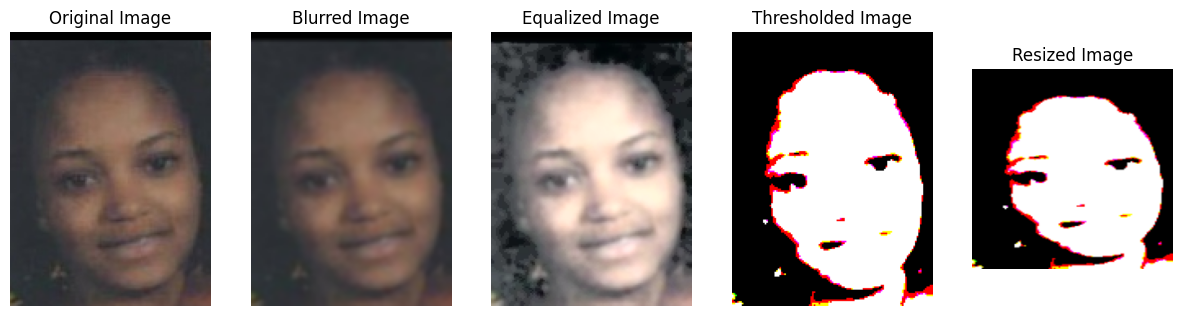

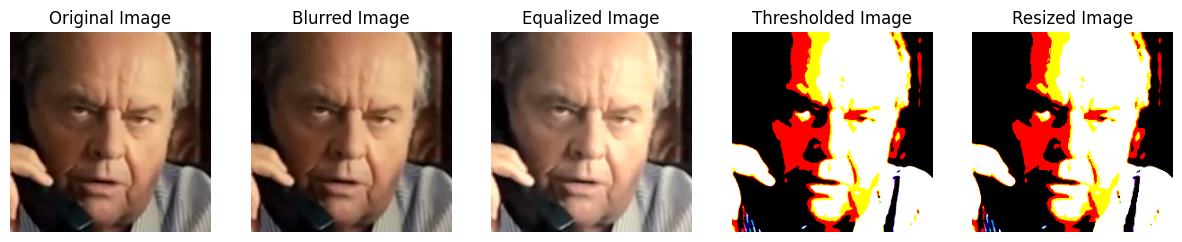

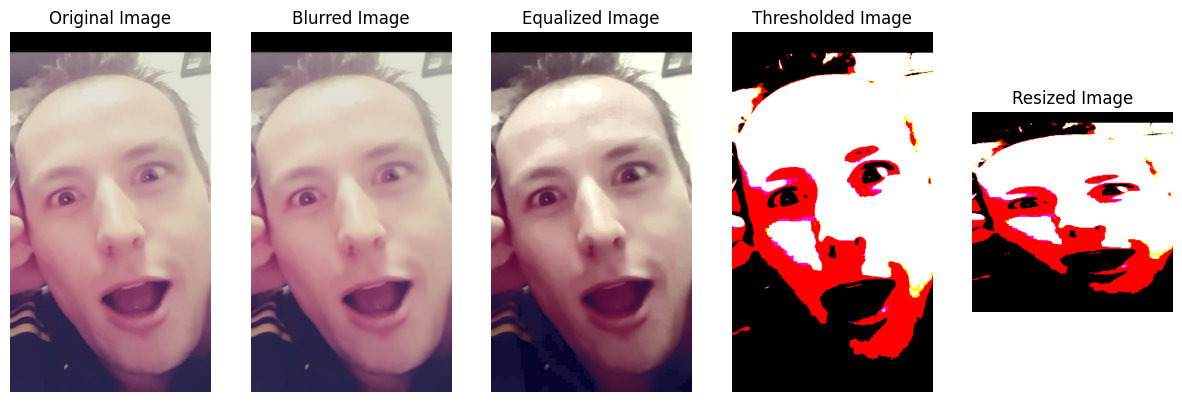

In [ ]:
# Applying preprocessing on the image dataset
train_images, train_labels, val_images, val_labels = preprocessing_images(image_label_pairs)

In [ ]:
# Split the validation data into two equal halves
val_data_size = len(val_images)
val_test_split_index = val_data_size // 2

# Split the validation images and labels
test_images = val_images[:val_test_split_index]
test_labels = val_labels[:val_test_split_index]

val_images = val_images[val_test_split_index:]
val_labels = val_labels[val_test_split_index:]


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import to_categorical

num_classes = 5

# Loading the EfficientNet base model with pre-trained weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adding additional layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

# Creating the transfer learning model
model = Model(inputs=base_model.input, outputs=output)

# Compiling the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Printing model summary
model.summary()

16705208/16705208 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

In [ ]:
from tensorflow.keras.utils import to_categorical

# Assuming train_labels and val_labels are your target labels
train_labels = to_categorical(train_labels, num_classes=num_classes)
val_labels = to_categorical(val_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [ ]:
# Training the model
history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(val_images, val_labels))

# Calculating average training accuracy
avg_train_accuracy = sum(history.history['accuracy']) / len(history.history['accuracy'])

# Calculating average validation accuracy
avg_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])

# Printing the average accuracies
print(f"Average Training Accuracy: {avg_train_accuracy}")
print(f"Average Validation Accuracy: {avg_val_accuracy}")


Epoch 1/10
57/57 [==============================] - 653s 11s/step - loss: 1.4211 - accuracy: 0.3850 - val_loss: 2.1243 - val_accuracy: 0.3783
Epoch 2/10
57/57 [==============================] - 647s 11s/step - loss: 1.0455 - accuracy: 0.5817 - val_loss: 1.4259 - val_accuracy: 0.5133
Epoch 3/10
57/57 [==============================] - 613s 11s/step - loss: 0.7708 - accuracy: 0.7094 - val_loss: 1.5744 - val_accuracy: 0.4683
Epoch 4/10
57/57 [==============================] - 643s 11s/step - loss: 0.5747 - accuracy: 0.7989 - val_loss: 1.8369 - val_accuracy: 0.4333
Epoch 5/10
57/57 [==============================] - 640s 11s/step - loss: 0.4807 - accuracy: 0.8422 - val_loss: 1.7629 - val_accuracy: 0.5233
Epoch 6/10
57/57 [==============================] - 596s 10s/step - loss: 0.4108 - accuracy: 0.8594 - val_loss: 1.5977 - val_accuracy: 0.5650
Epoch 7/10
57/57 [==============================] - 562s 10s/step - loss: 0.2982 - accuracy: 0.9000 - val_loss: 2.0452 - val_accuracy: 0.5533
Epoch 

In [ ]:
# Evaluating the model on test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

19/19 [==============================] - 38s 2s/step - loss: 1.5526 - accuracy: 0.6033
Test Loss: 1.5526089668273926, Test Accuracy: 0.6033333539962769


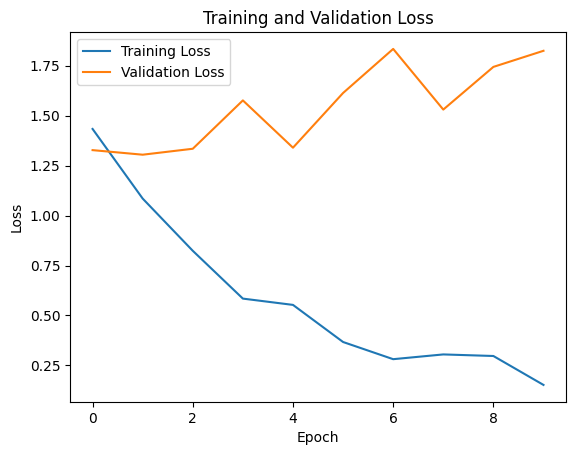

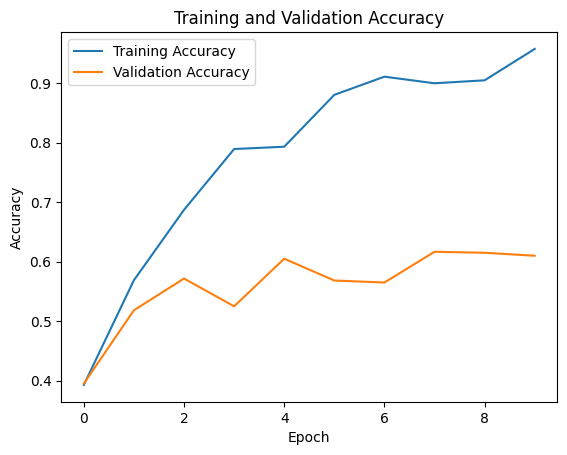

In [ ]:
# # Plotting training history
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Training and Validation Loss')
# plt.show()

# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Training and Validation Accuracy')
# plt.show()


**For Training Data**

57/57 [==============================] - 109s 2s/step


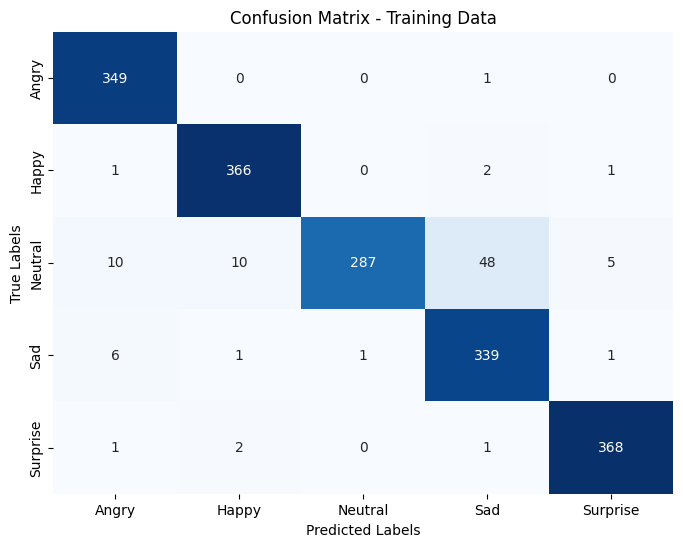

In [ ]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# class_labels = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

# # Predicting class labels
# train_predictions = model.predict(train_images)
# train_pred_labels = np.argmax(train_predictions, axis=1)

# # Computing confusion matrix
# conf_matrix = confusion_matrix(np.argmax(train_labels, axis=1), train_pred_labels)

# # Plotting the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.title('Confusion Matrix - Training Data')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.xticks(ticks=np.arange(num_classes) + 0.5, labels=class_labels)
# plt.yticks(ticks=np.arange(num_classes) + 0.5, labels=class_labels)
# plt.show()


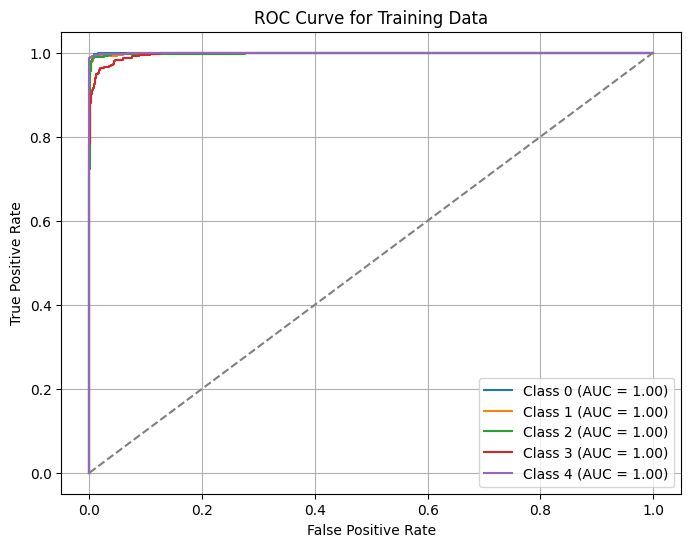

In [ ]:
# from sklearn.metrics import roc_curve, auc

# # Computing ROC curve and AUC for each class
# fpr_train = dict()
# tpr_train = dict()
# roc_auc_train = dict()
# for i in range(num_classes):
#     fpr_train[i], tpr_train[i], _ = roc_curve(train_labels[:, i], train_predictions[:, i])
#     roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# # Plotting ROC curve for each class
# plt.figure(figsize=(8, 6))
# for i in range(num_classes):
#     plt.plot(fpr_train[i], tpr_train[i], label=f'Class {i} (AUC = {roc_auc_train[i]:.2f})')

# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Training Data')
# plt.legend()
# plt.grid(True)
# plt.show()


**For Test Data**

19/19 [==============================] - 34s 2s/step


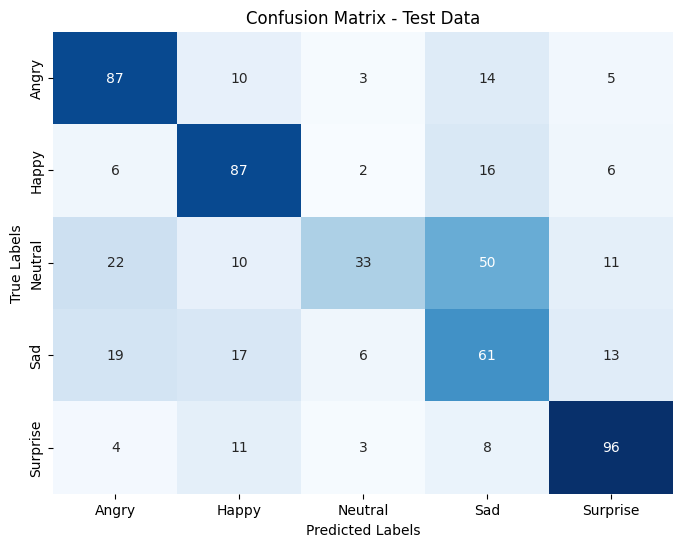

In [ ]:
# # Predicting class labels
# test_predictions = model.predict(test_images)
# test_pred_labels = np.argmax(test_predictions, axis=1)

# # Computing the confusion matrix
# conf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), test_pred_labels)

# # Plotting the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.title('Confusion Matrix - Test Data')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.xticks(ticks=np.arange(num_classes) + 0.5, labels=class_labels)
# plt.yticks(ticks=np.arange(num_classes) + 0.5, labels=class_labels)
# plt.show()

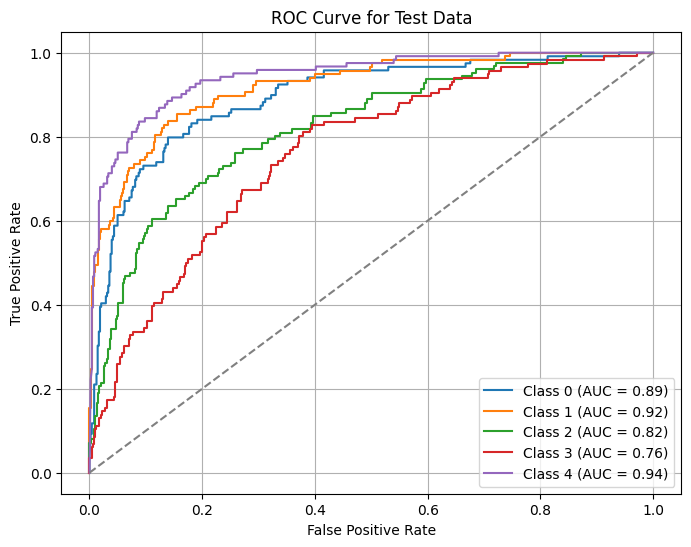

In [ ]:
# # Compute ROC curve and AUC for each class
# fpr_test = dict()
# tpr_test = dict()
# roc_auc_test = dict()
# for i in range(num_classes):
#     fpr_test[i], tpr_test[i], _ = roc_curve(test_labels[:, i], test_predictions[:, i])
#     roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

# # Plot ROC curve for each class
# plt.figure(figsize=(8, 6))
# for i in range(num_classes):
#     plt.plot(fpr_test[i], tpr_test[i], label=f'Class {i} (AUC = {roc_auc_test[i]:.2f})')

# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Test Data')
# plt.legend()
# plt.grid(True)
# plt.show()


**Performing Empirical Tuning**

In [ ]:
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.callbacks import EarlyStopping

# # Defining hyperparameters for tuning
# dropout_rates = [0.3, 0.5]
# learning_rates = [0.001, 0.0001]
# l2_regularizer = tf.keras.regularizers.l2(0.001)
# early_stopping = EarlyStopping(patience=3)

# best_val_accuracy = 0
# best_model = None

In [ ]:
# # Round 1: Hyperparameter Tuning
# for dropout_rate in dropout_rates:
#   for learning_rate in learning_rates:
#     # Building the model
#     base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#     x = GlobalAveragePooling2D()(base_model.output)
#     x = Dense(256, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     output = Dense(num_classes, activation='softmax')(x)
#     model = Model(inputs=base_model.input, outputs=output)

#     # Compiling the model
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

#     # Training the model
#     history = model.fit(train_images, train_labels, epochs=1, batch_size=32, validation_data=(val_images, val_labels))

#     # Evaluating on validation data
#     val_loss, val_accuracy = model.evaluate(val_images, val_labels)

#     # Saving the best model
#     if val_accuracy > best_val_accuracy:
#       best_val_accuracy = val_accuracy
#       best_model = model


In [ ]:
# # Round 2: Regularization Technique
# for dropout_rate in dropout_rates:
#   for learning_rate in learning_rates:
#     # Building the model
#     base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#     x = GlobalAveragePooling2D()(base_model.output)
#     x = Dense(256, activation='relu', kernel_regularizer=l2_regularizer)(x)
#     x = BatchNormalization()(x)
#     x = Dropout(dropout_rate)(x)
#     output = Dense(num_classes, activation='softmax')(x)
#     model = Model(inputs=base_model.input, outputs=output)

#     # Compiling the model
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

#     # Data Augmentation
#     datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
#                                          shear_range=0.1, zoom_range=0.1, horizontal_flip=True)
#     datagen.fit(train_images)

#     # Training the model
#     history = model.fit(datagen.flow(train_images, train_labels, batch_size=32), epochs=1,
#                         validation_data=(val_images, val_labels), callbacks=[early_stopping])

#     # Evaluating on validation data
#     val_loss, val_accuracy = model.evaluate(val_images, val_labels)

#     # Saving the best model
#     if val_accuracy > best_val_accuracy:
#       best_val_accuracy = val_accuracy
#       best_model = model


In [ ]:
# import cv2
# import numpy as np
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.efficientnet import preprocess_input

# # Prediction function
# def preprocess_and_predict(model, img_path, target_size=(224, 224)):
#     # Load and preprocess the image
#     img = image.load_img(img_path, target_size=target_size)
#     if img is None:
#         print("Error: Image not loaded.")
#         return None

#     # Converting image to array and preprocessing using EfficientNet's preprocessing
#     img_array = image.img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)
#     img_array = preprocess_input(img_array)

#     # Predicting the class label
#     preds = model.predict(img_array)
#     predicted_label = np.argmax(preds[0])

#     reverse_expression_labels = {v: k for k, v in expression_labels.items()}

#     # Converting the predicted label index to its corresponding expression label
#     predicted_expression_label = reverse_expression_labels[predicted_label]

#     return predicted_expression_label

In [ ]:
# image_path = "/content/00a7cb9cf18d3a015a9e932952f942fd4bcad8044bcef5e0c05de51d~angry.jpg"
# predicted_label = preprocess_and_predict(model, image_path)
# print("Predicted label:", predicted_label)

1/1 [==============================] - 0s 193ms/step
Predicted label: Happy


In [ ]:
# Creating s directory
os.makedirs('/content/Model', exist_ok=True)

# Saving the model
model.save('/content/Model/EfficientNet_Model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
